In [1]:
import numpy as np
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import warnings
warnings.filterwarnings('ignore')

/Users/yamadayuuta/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/yamadayuuta/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# 関数

In [2]:
#決定係数R2スコアを求める関数
def r2_calc(x,y):
    sum_1=0
    sum_2=0
    ave = np.sum(x)/len(x)
    for i in range(0,len(x)):
        sum_1 += (x[i]-y[i])**2
        sum_2 += (x[i]-ave)**2
    
    return 1-sum_1/sum_2

In [3]:
def r_calc(test,pred):
    n=len(test)
    ave_test = np.sum(test)/n
    ave_pred = np.sum(pred)/n
    a=0
    b=0
    c=0
    for i in range(0,len(test)):
        a += (test[i] - ave_test)*(pred[i] - ave_pred)
        b += (test[i] - ave_test)**2
        c += (pred[i] - ave_pred)**2
    
    a2 = a/n
    b2 = (b/n)**0.5
    c2 = (c/n)**0.5
    return a2/(b2*c2)

In [4]:
def feature_std_delite(x,out_index):  
    new_index = np.array(range(len(x[0])))
    index = np.array(range(len(x[0])-len(out_index)))
    for i in range(0,len(out_index)):
        new_index = np.delete(new_index, out_index[i]-i)
   
    new_x = np.zeros((len(x),len(x[0])-len(out_index)))
    for k in range(0,len(new_x)):      
        for i in range(0,len(new_x[0])):
            new_x[k][index[i]] = x[k][new_index[i]]
    return new_x 

In [5]:
def feature_select1(x):
    out_index=[] 
    for i in range(0,len(x[0])):
        flag=0
        value = x[0][i]
        for j in range(0,len(x)):
            if(value == x[j][i]):
                value = x[j][i]                
            else:
                if(flag!=1):
                    flag=1
        if(flag!=1):
            out_index.append(i)
        
    new_index = np.array(range(len(x[0])))
    index = np.array(range(len(x[0])-len(out_index)))
    for i in range(0,len(out_index)):
        new_index = np.delete(new_index, out_index[i]-i)
   
    new_x = np.zeros((len(x),len(x[0])-len(out_index)))
    for k in range(0,len(new_x)):      
        for i in range(0,len(new_x[0])):
            new_x[k][index[i]] = x[k][new_index[i]]
    return new_x ,out_index

In [6]:
def feature_select2(x,y):
    out_index=[] 
    for i in range(0,len(x[0])):
        flag=0
        value = x[0][i]
        for j in range(0,len(x)):
            if(value == x[j][i]):
                value = x[j][i]                
            else:
                if(flag!=1):
                    flag=1
        if(flag!=1):
            out_index.append(i)
        
    new_index = np.array(range(len(x[0])))
    index = np.array(range(len(x[0])-len(out_index)))
    for i in range(0,len(out_index)):
        new_index = np.delete(new_index, out_index[i]-i)
   
    new_x = np.zeros((len(x),len(x[0])-len(out_index)))
    new_y = np.zeros((len(y),len(y[0])-len(out_index)))
    for k in range(0,len(new_x)):
        if(k<len(new_y)):
            for i in range(0,len(new_y[0])):
                new_x[k][index[i]] = x[k][new_index[i]]
                new_y[k][index[i]] = y[k][new_index[i]]
        else:        
            for i in range(0,len(new_x[0])):
                new_x[k][index[i]] = x[k][new_index[i]]
    return new_x,new_y   

In [7]:
def rank_backsort(x):
    y = np.sort(x)
    y = y[::-1]
    z = np.zeros(len(x))
    
    for i in range(0,len(x)):
        for j in range(0,len(y)):
            if(x[i] == y[j]):
                z[i] = j+1
                break
    return z

In [8]:
def rank_indent(x):
    lst=[]
    for i in range(1,11):
        for j in range(0,len(x)):
            if(i == x[j]):
                lst.append(j)
    return lst

In [9]:
def nfeature(x,oi):
    new_index = np.array(range(len(x)))
    for i in range(0,len(oi)):
        new_index = np.delete(new_index, oi[i]-i)
   
    new_x = []
    for i in range(0,len(new_index)):      
        new_x.append(x[new_index[i]])
    return new_x

In [91]:
def prediction(x):
    tuned_parameters = [
    {'C': [2**(-3), 2**(-2), 2**(-1), 1, 2, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10], 'kernel': ['linear']},
    {'C': [2**(-3), 2**(-2), 2**(-1), 1, 2, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10], 'kernel': ['rbf'], 'gamma': [2**(-10), 2**(-9), 2**(-8), 2**(-7), 2**(-6), 2**(-5), 2**(-4), 2**(-3), 2**(-2), 2**(-1), 1 ]},
    ]
    
    train_data = np.loadtxt("furukawa_全体_標準化なし_rank順_名前なし.csv",delimiter=",",dtype=float)
    train_feature=train_data[:,0:x]
    train_label=train_data[:,-1]
    
    test_data = np.loadtxt('wang_全体_標準化なし_rank順_名前なし.csv', delimiter=',', dtype=float)
    test_feature = test_data[:, 0:x]
    test_label = test_data[:, -1] 

    scaler = StandardScaler()
    scaler.fit(train_feature)
    train_feature = scaler.transform(train_feature)
    test_feature = scaler.transform(test_feature)

    grid = GridSearchCV(SVR(),tuned_parameters,cv=5,scoring='r2')
    grid.fit(train_feature,train_label)
    
    clf = SVR(C=grid.best_params_['C'],kernel='rbf',gamma=grid.best_params_['gamma'],epsilon=0.1)
    clf.fit(train_feature, train_label)
    pred = clf.predict(test_feature)

    R2 = r2_score(test_label,pred)
    return R2

# パラメータ定義

In [22]:
tuned_parameters = [
    {'C': [2**(-3), 2**(-2), 2**(-1), 1, 2, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10], 'kernel': ['linear']},
    {'C': [2**(-3), 2**(-2), 2**(-1), 1, 2, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10], 'kernel': ['rbf'], 'gamma': [2**(-10), 2**(-9), 2**(-8), 2**(-7), 2**(-6), 2**(-5), 2**(-4), 2**(-3), 2**(-2), 2**(-1), 1 ]},
    ]

# 分散0を除去

In [57]:
data = np.loadtxt('furukawa_全体206次元_名前なし.csv', delimiter=',', dtype=float)
feature = data[:,0:206]
train_label = data[:,-1]
out_index=[]
train_feature,out_index = feature_select1(feature)

In [58]:
file = open("furukawa_全体159次元_分散0除去_名前付き.csv","w")
name = np.loadtxt("特徴量_名前一覧.csv",delimiter=",",dtype=str)
#分散0をここで除去
an_feature = nfeature(name,out_index)

for i in range(0,len(an_feature)):
    file.write(an_feature[i])
    file.write(",")
file.write("logPapp\n")
a = 0
for i in range(0,393):
    for j in range(0,len(an_feature)):
        file.write(str(train_feature[i][j]))
        file.write(",")
    file.write(str(train_label[i]))
    file.write("\n")
file.close()

In [60]:
data = np.loadtxt("wang_全体206次元_名前なし.csv",delimiter=",",dtype=float)
test_feature = data[:,0:206]
test_label = data[:,-1]

test_feature = feature_std_delite(test_feature,out_index)

file = open("wang_全体159次元_分散0除去_名前付き.csv","w")

for i in range(0,len(an_feature)):
    file.write(an_feature[i])
    file.write(",")
file.write("logPapp\n")

for i in range(0,54):
    for j in range(0,len(an_feature)):
        file.write(str(test_feature[i][j]))
        file.write(",")
    file.write(str(test_label[i]))
    file.write("\n")
file.close()

# ランダムフォレストで特徴量を選択
標準化しないよ

In [15]:
from sklearn.grid_search import GridSearchCV
tuned_parameters = {'n_estimators'  : [10, 100, 1000, 10000], 'max_features' : ['auto','sqrt','log2']}

In [16]:
data = np.loadtxt('furukawa_全体159次元_分散0除去_名前なし.csv', delimiter=',', dtype=float)
train_feature = data[:,0:159]
train_label = data[:,-1]

grid = GridSearchCV(RandomForestRegressor(),tuned_parameters,cv=5,scoring='r2') # モデルの評価関数の指定
grid.fit(train_feature,train_label)
print(grid.best_params_)

{'max_features': 'auto', 'n_estimators': 100}


In [18]:
data = np.loadtxt('furukawa_全体159次元_分散0除去_名前なし.csv', delimiter=',', dtype=float)

feature = data[:,0:159]
label = data[:,-1]

importance=np.zeros(159)
regr = RandomForestRegressor(n_estimators=100,max_features='auto')
kf = KFold(n_splits = 5, shuffle = True)
for train_index, test_index in kf.split(feature):
    train_feature, train_label, test_feature, test_label = np.array(feature)[train_index], np.array(label)[train_index], np.array(feature)[test_index], np.array(label)[test_index]
    regr.fit(train_feature,train_label)
    importance += regr.feature_importances_

In [19]:
rank_index = rank_backsort(importance)

In [62]:
file=open("furukawa_全体_標準化なし_rank順_名前付き.csv","w")
data = np.loadtxt('furukawa_全体159次元_分散0除去_名前付き.csv', delimiter=',', dtype=str)
feature=data[:,0:160]
label = data[:,-1]

for i in range(394):
    for j in range(1,160):
            for k in range(159):
                if(j==rank_index[k]):
                    file.write(feature[i][k])
                    file.write(",")
    file.write(label[i])
    file.write("\n")
file.close()

In [63]:
file=open("wang_全体_標準化なし_rank順_名前付き.csv","w")
data = np.loadtxt('wang_全体159次元_分散0除去_名前付き.csv', delimiter=',', dtype=str)
feature=data[:,0:160]
label = data[:,-1]

for i in range(55):
    for j in range(1,160):
            for k in range(159):
                if(j==rank_index[k]):
                    file.write(feature[i][k])
                    file.write(",")
    file.write(label[i])
    file.write("\n")
file.close()

# パラメータ

In [23]:
tuned_parameters = [
    {'C': [2**(-3), 2**(-2), 2**(-1), 1, 2, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10], 'kernel': ['linear']},
    {'C': [2**(-3), 2**(-2), 2**(-1), 1, 2, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10], 'kernel': ['rbf'], 'gamma': [2**(-10), 2**(-9), 2**(-8), 2**(-7), 2**(-6), 2**(-5), 2**(-4), 2**(-3), 2**(-2), 2**(-1), 1 ]},
    ]

# 上位5個

In [93]:
train_data = np.loadtxt("furukawa_全体_標準化なし_rank順_名前なし.csv",delimiter=",",dtype=float)
train_feature=train_data[:,0:5]
train_label=train_data[:,-1]

In [94]:
scaler = StandardScaler()
scaler.fit(train_feature)
train_feature = scaler.transform(train_feature)

In [95]:
grid = GridSearchCV(SVR(),tuned_parameters,cv=5,scoring='r2')
grid.fit(train_feature,train_label)
print(grid.best_params_)

{'C': 1, 'gamma': 0.0625, 'kernel': 'rbf'}


In [96]:
test_data = np.loadtxt('wang_全体_標準化なし_rank順_名前なし.csv', delimiter=',', dtype=float)
test_feature = test_data[:, 0:5]
test_label = test_data[:, -1]
test_feature = scaler.transform(test_feature)

In [97]:
clf = SVR(C=1,kernel='rbf',gamma=0.0625,epsilon=0.1)
clf.fit(train_feature, train_label)
pred = clf.predict(test_feature)

In [98]:
R2 = r2_score(test_label,pred)
rmse = (mean_squared_error(test_label,pred))**0.5
r = r_calc(test_label,pred)

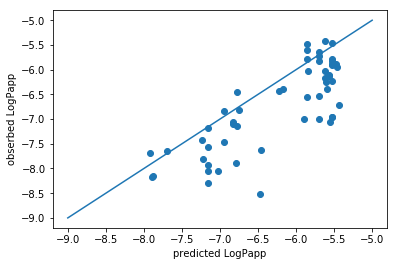

SVR: r2 0.305861, RMSE 0.716406, r 0.796296


In [99]:
x = np.linspace(-9,-5)  
y = x              
plt.plot(x,y)      

y1 = pred
y2 = test_label
plt.scatter(y1,y2)

plt.ylabel('obserbed LogPapp')
plt.xlabel('predicted LogPapp')
plt.show()
print ("SVR: r2 %f, RMSE %f, r %f" % (R2, rmse, r))

In [84]:
train_data = np.loadtxt("furukawa_全体_標準化なし_rank順_名前なし.csv",delimiter=",",dtype=float)
train=train_data[:,0:159]

test_data = np.loadtxt('wang_全体_標準化なし_rank順_名前なし.csv', delimiter=',', dtype=float)
test = test_data[:,0:159]

scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

for i in range(159):
    if(test[0][i]>3 or test[0][i] < -3):
        print("****")

****
****
****
****
****
****
****
****
****
****


# 特徴量からtestで分散0を除き、標準化したとき3~-3から外れるものを除去

In [13]:
train_data = np.loadtxt("furukawa_全体_標準化なし_rank順_名前なし.csv",delimiter=",",dtype=float)
train=train_data[:,0:159]
test_data = np.loadtxt('wang_全体_標準化なし_rank順_名前なし.csv', delimiter=',', dtype=float)
test = test_data[:,0:159]
scaler = StandardScaler()
scaler.fit(train)
test = scaler.transform(test)
test[0][10]

-10.985962231013671

In [7]:
train_data = np.loadtxt("furukawa_全体_標準化なし_rank順_名前付き.csv",delimiter=",",dtype=str)
train=train_data[:,0:159]
scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)

train[0][10]

'GCUT_SMR_0'

In [65]:
train_data = np.loadtxt("furukawa_全体_標準化なし_rank順_名前なし.csv",delimiter=",",dtype=float)
train=train_data[:,0:159]

test_data = np.loadtxt('wang_全体_標準化なし_rank順_名前なし.csv', delimiter=',', dtype=float)
test = test_data[:,0:159]

scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

f=open("外れ値.csv","w")

for i in range(len(test)):
    for j in range(159):
        if(test[i][j] > 3 or test[i][j] < -3):
            f.write(str(i))
            f.write(",")
            f.write(str(j))
            f.write("\n")
f.close()

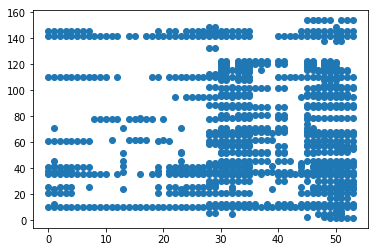

In [2]:
data = np.loadtxt('外れ値.csv', delimiter=',', dtype=float)

num = data[:,0:1]
label = data[:,1]
plt.scatter(num,label)

In [3]:
val = list(set(label))

In [4]:
val = np.sort(val)

In [87]:
val = np.array([  2.,   3.,   5.,   6.,   7.,  10.,  11.,  12.,  13.,  17.,  21.,
        24.,  26.,  28.,  30.,  35.,  36.,  37.,  38.,  39.,  41.,  42.,
        43.,  44.,  46.,  52.,  53.,  55.,  57.,  58.,  59.,  61.,  62.,
        63.,  66.,  67.,  68.,  69.,  71.,  74.,  78.,  79.,  81.,  87.,
        89.,  95.,  96.,  97., 102., 103., 104., 106., 108., 110., 113., 114.,
       115., 116., 118., 120., 121., 122., 123., 133., 138., 142., 144.,
       146., 149., 150., 154., 156., 157., 158.])

In [5]:
len(val)

69

In [51]:
train_data = np.loadtxt("furukawa_全体_標準化なし_rank順_名前なし.csv",delimiter=",",dtype=float)
test_data = np.loadtxt('wang_全体_標準化なし_rank順_名前なし.csv', delimiter=',', dtype=float)
oi=[]
for i in range(159):
    train = train_data[:,i]
    test = test_data[:,i]
    
    train_ave=sum(train)/len(train)
    test_ave=sum(test)/len(test)
    
    for j in range(len(train)):
        train_std=(((train_ave - train[j])**2)/len(train))**0.5
    for j in range(len(test)):
        test_std=(((test_ave - test[j])**2)/len(test))**0.5
    
    if(test_std==0):
        print(i)

106
150
156
157
158


In [81]:
index = list(np.array(range(160)))
for i in range(len(val)):
    index.remove(val[i])

In [82]:
train_data = np.loadtxt("furukawa_全体_標準化なし_rank順_名前付き.csv",delimiter=",",dtype=str)
train=train_data[:,0:]

test_data = np.loadtxt('wang_全体_標準化なし_rank順_名前付き.csv', delimiter=',', dtype=str)
test = test_data[:,0:]

file=open("FURUKAWA_全体_rank_名前.csv","w")
file2=open("WANG_全体_rank_名前.csv","w")

for i in range(394):
    for j in range(len(index)):
        if(j==(len(index)-1)):
            file.write(train[i][index[j]])
            file.write("\n")
        else:    
            file.write(train[i][index[j]])
            file.write(",")
file.close()

for i in range(55):
    for j in range(len(index)):
        if(j==(len(index)-1)):
            file2.write(test[i][index[j]])
            file2.write("\n")
        else:
            file2.write(test[i][index[j]])
            file2.write(",")
file2.close()

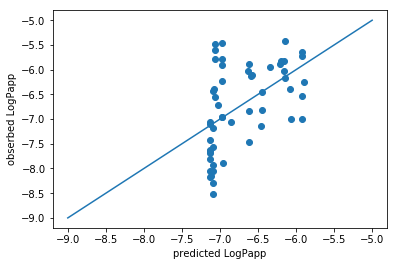

SVR: r2 0.247010, RMSE 0.746157, r 0.497355


In [54]:
train_data = np.loadtxt("furukawa_全体_標準化なし_rank順_名前なし.csv",delimiter=",",dtype=float)
train_feature=train_data[:,0:159]
train_label=train_data[:,-1]
test_data = np.loadtxt('wang_全体_標準化なし_rank順_名前なし.csv', delimiter=',', dtype=float)
test_feature = test_data[:, 0:159]
test_label = test_data[:, -1] 

train_feature=feature_std_delite(train_feature,oi)
test_feature=feature_std_delite(test_feature,oi)

scaler = StandardScaler()
scaler.fit(train_feature)
train_feature = scaler.transform(train_feature)
test_feature = scaler.transform(test_feature)

grid = GridSearchCV(SVR(),tuned_parameters,cv=5,scoring='r2')
grid.fit(train_feature,train_label)

clf = SVR(C=grid.best_params_['C'],kernel='rbf',gamma=grid.best_params_['gamma'],epsilon=0.1)
clf.fit(train_feature, train_label)
pred = clf.predict(test_feature)


R2 = r2_score(test_label,pred)
rmse = (mean_squared_error(test_label,pred))**0.5
r = r_calc(test_label,pred)

x = np.linspace(-9,-5)  
y = x              
plt.plot(x,y)      

y1 = pred
y2 = test_label
plt.scatter(y1,y2)

plt.ylabel('obserbed LogPapp')
plt.xlabel('predicted LogPapp')
plt.show()
print ("SVR: r2 %f, RMSE %f, r %f" % (R2, rmse, r))

# 特徴量の数を変えてのR2の変化を見る

In [41]:
prediction(159)

-0.09905116805664083

In [43]:
left = np.array([5.,   10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,
        65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110., 115.,
       120., 125., 130., 135., 140., 145., 150., 155.,159])

In [44]:
height = np.array([0.30520265, 0.16322817, -0.07392958, -0.13153249, -0.12973173, -0.10472327,
       -0.01650575, -0.10970888, -0.08043765, -0.0772543 , -0.06341219,
       -0.04401366, -0.22144042, -0.16288931, -0.14762295, -0.07841058,
       -0.10428281, -0.09276444, -0.08108513, -0.07474561, -0.03506187,
       -0.44723246, -0.05570276, -0.31829744, -0.26533527, -0.17325842,
       -0.17332671, -0.15951005, -0.14010716, -0.11668033, -0.09842133,-0.09905116805664083])

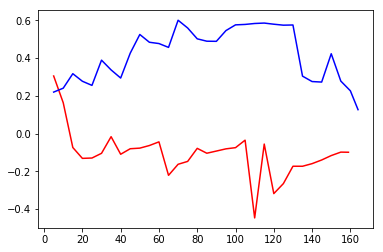

In [49]:
plt.plot(left, height,c="r")
plt.plot(left2,height2,c="b")


In [45]:
left2=np.array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
         60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110.,
        115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,164])

In [46]:
height2 = np.array([0.21987184, 0.24062802, 0.31735777, 0.27736411, 0.25543389,
        0.38916589, 0.33743842, 0.29436621, 0.42630489, 0.52526711,
        0.48406599, 0.47719409, 0.45684882, 0.60076869, 0.55968636,
        0.50224148, 0.48966093, 0.48900861, 0.54592638, 0.5762829 ,
        0.57857083, 0.58358115, 0.58578977, 0.57973981, 0.57461616,
        0.57563324, 0.3044331 , 0.27572085, 0.27301034, 0.42317438,
        0.27825248, 0.22665152,0.12665612965881679])

# 新しいやつ

In [82]:
def std_prediction(x):
    tuned_parameters = [
    {'C': [2**(-3), 2**(-2), 2**(-1), 1, 2, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10], 'kernel': ['linear']},
    {'C': [2**(-3), 2**(-2), 2**(-1), 1, 2, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10], 'kernel': ['rbf'], 'gamma': [2**(-10), 2**(-9), 2**(-8), 2**(-7), 2**(-6), 2**(-5), 2**(-4), 2**(-3), 2**(-2), 2**(-1), 1 ]},
    ]
    
    train_data = np.loadtxt("furukawa_全体_標準偏差_rank_名前なし.csv",delimiter=",",dtype=float)
    train_feature=train_data[:,0:x]
    train_label=train_data[:,-1]
    
    test_data = np.loadtxt('wang_全体_標準偏差_rank_名前なし.csv', delimiter=',', dtype=float)
    test_feature = test_data[:, 0:x]
    test_label = test_data[:, -1] 

    scaler = StandardScaler()
    scaler.fit(train_feature)
    train_feature = scaler.transform(train_feature)
    test_feature = scaler.transform(test_feature)

    grid = GridSearchCV(SVR(),tuned_parameters,cv=5,scoring='r2')
    grid.fit(train_feature,train_label)
    
    clf = SVR(C=grid.best_params_['C'],kernel='rbf',gamma=grid.best_params_['gamma'],epsilon=0.1)
    clf.fit(train_feature, train_label)
    pred = clf.predict(test_feature)

    R2 = r2_score(test_label,pred)
    return R2

In [102]:
new_height

array([0.30586107, 0.15731571, 0.25135017, 0.19836512, 0.23258199,
       0.28073505, 0.30637214, 0.32026624, 0.2839451 , 0.33193787,
       0.32292838, 0.42074366, 0.33692924, 0.36794072, 0.33410775,
       0.35427869, 0.3582462 , 0.3629121 , 0.35661716, 0.34375701,
       0.28915369, 0.25000543, 0.26456703, 0.26402222, 0.26607222,
       0.27065188, 0.30426471, 0.21618254, 0.20384128, 0.24929109])

In [101]:
height

array([ 0.30586107,  0.15731571, -0.07037814, -0.13496187, -0.12419209,
       -0.10643833, -0.01868136, -0.09720445, -0.06978959, -0.06911868,
       -0.05705233, -0.03892395, -0.10784927, -0.15009379, -0.12881943,
       -0.0668665 , -0.08974512, -0.07833596, -0.06804084, -0.06132237,
       -0.37425641, -0.37436469, -0.46258307, -0.2605688 , -0.20757829,
       -0.12676483, -0.1286714 , -0.11905786, -0.10575435, -0.09142512,
       -0.0761905 ])

In [92]:
prediction(5)

0.3058610729046013

In [90]:
std_prediction(5)

0.3058610729046013

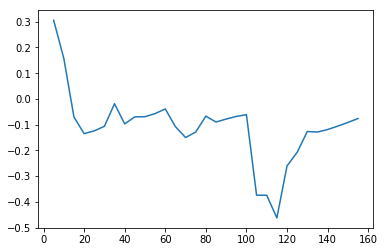

In [100]:
import numpy as np
import matplotlib.pyplot as plt

left = np.zeros(31)
height = np.zeros(31)
# 折れ線グラフを出力
for i in range(31):
    left[i] = 5*(i+1)
    height[i] = prediction((i+1)*5)
plt.plot(left, height)

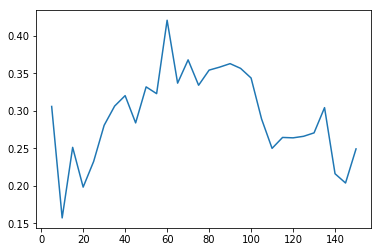

In [87]:
new_left = np.zeros(30)
new_height = np.zeros(30)
# 折れ線グラフを出力
for i in range(30):
    new_left[i] = 5*(i+1)
    new_height[i] = std_prediction((i+1)*5)
plt.plot(new_left, new_height)

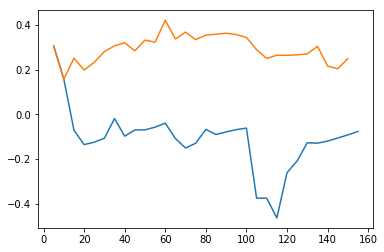

In [103]:
plt.plot(left,height)
plt.plot(new_left, new_height)